#### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 12
# from scipy.signal import butter, filtfilt, freqz, iirnotch, lfilter

In [2]:
custom_colors = ['darkblue', 'darkgreen', 'darkgoldenrod', 'darkmagenta', 'darkcyan', 'gray']

#### ECG Signal Preprocessing

##### Bandpass filter

In [7]:
def bandpass_filter(signal, lowcut=0.67, highcut=150.0, fs=1000.0):

    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist

    b, a = butter(3, [low, high], btype='band')
    w, h = freqz(b, a, worN=2000)
    h_dB = 20 * np.log10(abs(h + 1e-12))

    filtered_signal = filtfilt(b, a, signal)
    filter_properties = {
        'b': b,
        'a': a,
        'w': w,
        'h': h,
        'h_dB': h_dB
    }

    return filtered_signal, filter_properties

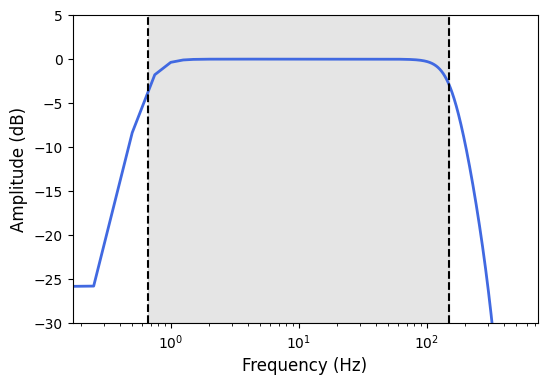

In [182]:
fs = 1000.0
lowcut = 0.67
highcut = 150.0
filtered_signal, filter_properties = bandpass_filter(
    signal=np.zeros(1000),
    lowcut=lowcut,
    highcut=highcut,
    fs=fs
)
radian_arr = fs / (2 * np.pi) * filter_properties['w']

ymin = -30
ymax = 5
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(radian_arr, filter_properties['h_dB'], color='royalblue', linewidth=2)
ax.vlines([lowcut, highcut], ymin, ymax, color='k', linestyle='--')
ax.fill_betweenx([ymin, ymax], lowcut, highcut, color='k', alpha=0.1)
ax.set_ylim(ymin, ymax)
ax.set_xscale('log')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude (dB)')

fig.savefig('figures/bandpass_filter_response.pdf', bbox_inches='tight')
plt.show()

##### Power-line filter

In [3]:
def powerline_filter(signal, fs=1000.0):

    f0 = 50.0
    Q = 30.0

    b, a = iirnotch(f0, Q, fs)
    w, h = freqz(b, a, worN=2000)
    h_dB = 20 * np.log10(abs(h))
    
    filtered_signal = lfilter(b, a, signal)
    filter_properties = {
        'b': b,
        'a': a,
        'w': w,
        'h': h,
        'h_dB': h_dB
    }

    return filtered_signal, filter_properties

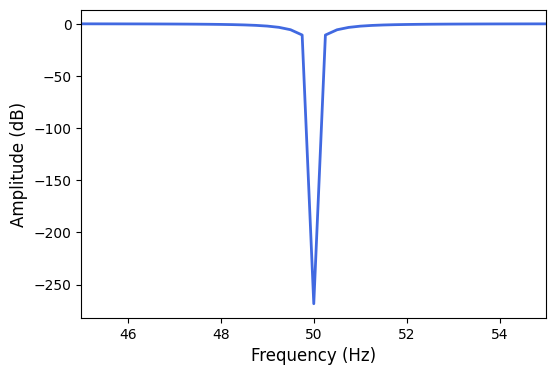

In [179]:
filtered_signal, filter_properties = powerline_filter(
    signal=np.zeros(1000),
    fs=fs
)
radian_arr = fs / (2 * np.pi) * filter_properties['w']

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(radian_arr, filter_properties['h_dB'], color='royalblue', linewidth=2)
ax.set_xlim(45, 55)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude (dB)')

fig.savefig('figures/powerline_filter_response.pdf', bbox_inches='tight')
plt.show()

##### Exhibit Denoising

In [185]:
ecg_record = wfdb.rdrecord('data/autonomic-aging-cardiovascular/1.0.0/0035', sampto=3000)
signal = ecg_record.p_signal[:, 0]
fs = ecg_record.fs
filtered_signal, _ = bandpass_filter(signal, lowcut=0.67, highcut=150, fs=fs)
filtered_signal, _ = powerline_filter(filtered_signal, fs=fs)

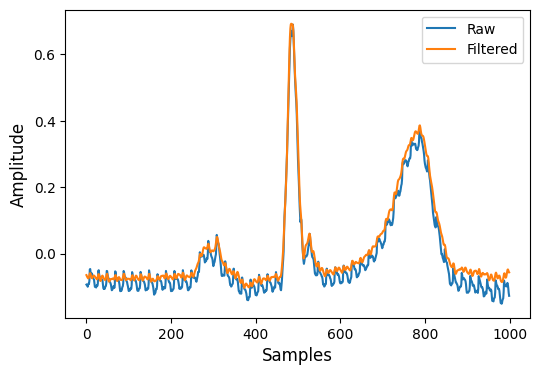

In [191]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(signal[1000:2000], label='Raw')
ax.plot(filtered_signal[1000:2000], label='Filtered')
ax.legend()
ax.set_xlabel('Samples')
ax.set_ylabel('Amplitude')
plt.show()

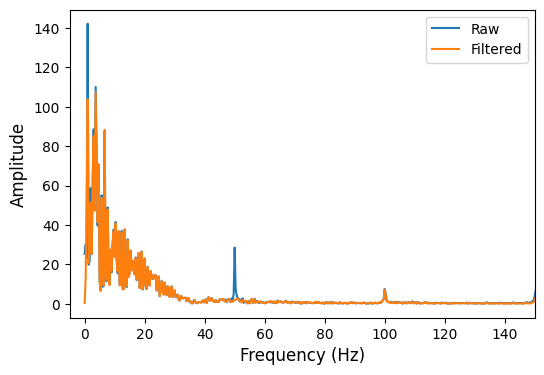

In [198]:
# Compute the FFT
raw_fft_vals = np.fft.rfft(signal)
raw_fft_freq = np.fft.rfftfreq(len(signal), 1.0/fs)
filtered_fft_vals = np.fft.rfft(filtered_signal)
fitlered_fft_freq = np.fft.rfftfreq(len(filtered_signal), 1.0/fs)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(raw_fft_freq, np.abs(raw_fft_vals), label='Raw')
ax.plot(fitlered_fft_freq, np.abs(filtered_fft_vals), label='Filtered')

ax.legend()
# ax.set_xscale('log')
ax.set_xlim(-5, 150)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude')

plt.show()

### Dataset Loading

In [3]:
import os
import wfdb
from tqdm import tqdm
from biosppy.signals import ecg
from sklearn.preprocessing import MinMaxScaler

In [4]:
def load_ecg_signal(file_name):
    try:
        record = wfdb.rdrecord(file_name)
        signal = record.p_signal[:, 0]
        fs = record.fs
    except Exception as e:
        print(f'Error processing {file_name}: {e}')
        signal, fs = None, None
    finally:
        return signal, fs

In [5]:
def extract_and_scale_templates(signal, fs):
    try:
        ecg_dict = ecg.ecg(signal, sampling_rate=fs, show=False)
        templates = ecg_dict['templates'][:20]
        scaled_templates = MinMaxScaler().fit_transform(templates.T).T
    except Exception as e:
        # print(f'Error processing signal: {e}')
        scaled_templates = []
    finally:
        return scaled_templates

In [27]:
def create_pulse_series(signal, fs):
    try:
        ecg_dict = ecg.ecg(signal, sampling_rate=fs, show=False)
        rpeaks = ecg_dict['rpeaks']
        filtered_signal = ecg_dict['filtered']
        pulse_series = []
        curr_rpeak = 0
        j = 0
        while j < 4:
            start_idx = rpeaks[curr_rpeak] - 100
            end_idx = start_idx + 10000
            if end_idx > len(filtered_signal):
                break
            pulse_series.append(
                filtered_signal[start_idx:end_idx]
            )
            curr_rpeak = np.where(rpeaks > end_idx)[0][0]
            j += 1
        scaled_pulse_series = MinMaxScaler().fit_transform(np.array(pulse_series).T).T
    except Exception as e:
        # print(f'Error processing signal: {e}')
        scaled_pulse_series = []
    finally:
        return scaled_pulse_series

In [28]:
def read_ecg_dataset(dataset_root, start_idx=0, end_idx=500):
    data_files = [f for f in os.listdir(dataset_root) if f.endswith('.dat')]
    data = []
    pbar = tqdm(total=end_idx-start_idx)
    for file_name in data_files[start_idx:end_idx]:
        file_name_without_ext = file_name[:-4]
        signal, fs = load_ecg_signal(os.path.join(dataset_root, file_name_without_ext))
        if signal is not None:
            # templates = extract_and_scale_templates(signal, fs)
            # data.extend(templates)
            pulses = create_pulse_series(signal, fs)
            data.extend(pulses)
        pbar.update(1)
    pbar.close()
    return np.array(data)

In [29]:
X_train = read_ecg_dataset(
    dataset_root='data/autonomic-aging-cardiovascular/1.0.0',
    start_idx=0,
    end_idx=700
)

100%|██████████| 700/700 [08:21<00:00,  1.40it/s]


In [30]:
X_test = read_ecg_dataset(
    dataset_root='data/autonomic-aging-cardiovascular/1.0.0',
    start_idx=700,
    end_idx=900
)

100%|██████████| 200/200 [02:17<00:00,  1.46it/s]


In [31]:
X_val = read_ecg_dataset(
    dataset_root='data/autonomic-aging-cardiovascular/1.0.0',
    start_idx=900,
    end_idx=1100
)

100%|██████████| 200/200 [02:27<00:00,  1.36it/s]


In [33]:
X_train.shape, X_test.shape, X_val.shape

((2708, 10000), (764, 10000), (780, 10000))

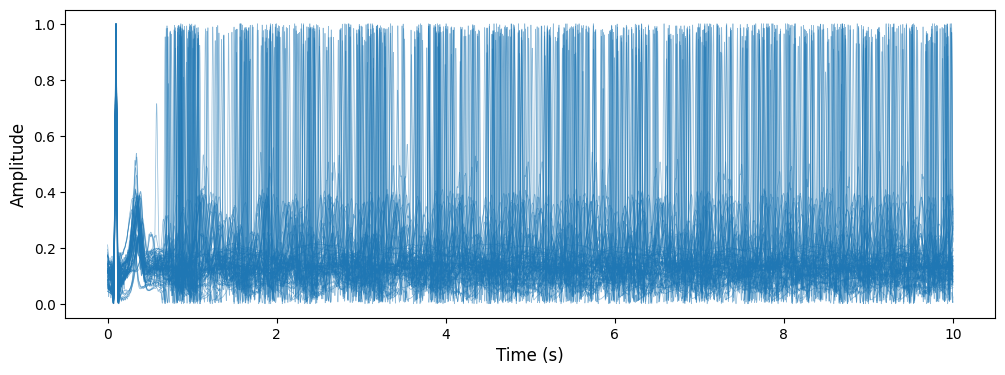

In [34]:
fig, ax = plt.subplots(figsize=(12, 4))
x_arr = np.linspace(0, len(X_train[0])/1000, 10000)
for template in X_train[:75]:
    ax.plot(x_arr, template, color='tab:blue', linewidth=0.5, alpha=0.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
plt.show()

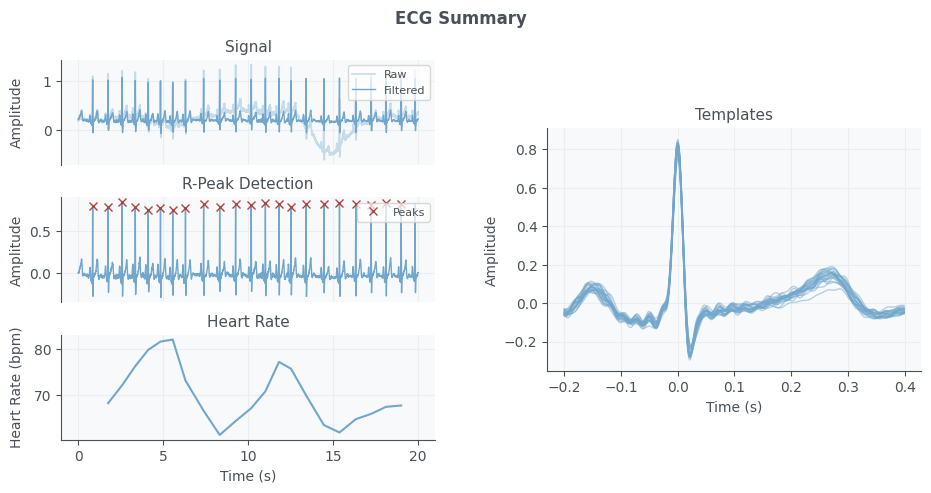

In [144]:
example_signal = ecg.ecg(signal=raw_signal[:20000], sampling_rate=fs, show=True)

In [8]:
# Split the dataset into training, test and validation
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(scaled_templates, test_size=0.4, random_state=42)
X_test, X_val = train_test_split(X_test, test_size=0.5, random_state=42)
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [60]:
print(f'Training: {X_train.shape}, Test: {X_test.shape}, Validation: {X_val.shape}')

Training: (636, 600), Test: (212, 600), Validation: (212, 600)


### Autoencoder Model

In [15]:
from keras.models import Model
from keras.layers import Input, Dense
from tensorflow.keras.models import clone_model

2024-05-27 16:37:50.647766: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-27 16:37:53.799239: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 16:37:58.768146: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Model Definition

In [22]:
input_dim = 10000
encoding_dim = 32
input_signal = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_signal)
decoded = Dense(input_dim, activation='sigmoid')(encoded)
autoencoder = Model(input_signal, decoded)

In [23]:
encoder = Model(input_signal, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [24]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

#### Hyperparameter tuning

In [49]:
learning_rate_arr = [0.0001, 0.001, 0.01, 0.1]
history_dict = {}
for lr in learning_rate_arr:
    autoencoder = clone_model(autoencoder)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    history = autoencoder.fit(
        X_train, X_train,
        epochs=50,
        batch_size=32,
        shuffle=True,
        validation_data=(X_val, X_val)
    )
    history_dict[lr] = history

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6099 - val_loss: 0.5586
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5366 - val_loss: 0.5084
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4988 - val_loss: 0.5031
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4992 - val_loss: 0.5031
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4982 - val_loss: 0.5047
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5019 - val_loss: 0.5014
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4975 - val_loss: 0.5021
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4963 - val_loss: 0.5021
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5008 - val_loss: 0.5012
Epoch 10/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4989 - val_loss: 0.5001
Epoch 11/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4967 - val_loss: 0.5014
Epoch 12/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4974 - val_lo

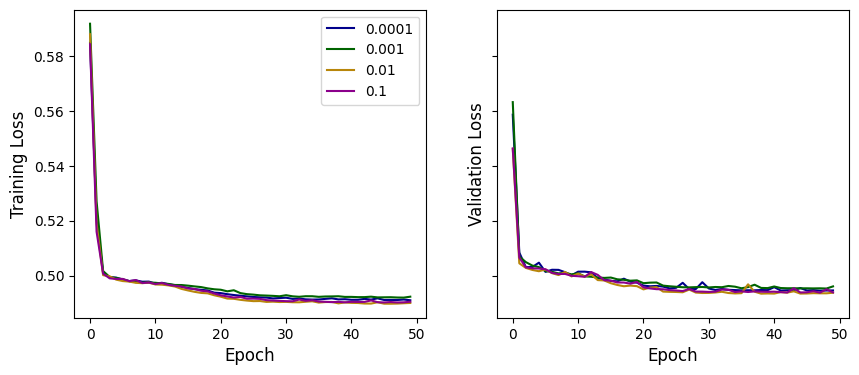

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharex=True, sharey=True)
for i, (lr, history) in enumerate(history_dict.items()):
    ax[0].plot(history.history['loss'], color=custom_colors[i], label=f'{lr}')
    ax[1].plot(history.history['val_loss'], color=custom_colors[i], label=f'{lr}')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Training Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Validation Loss')
ax[0].legend()
plt.show()

In [ ]:
batch_sizes = [4, 8, 16, 32, 64, 128]
histories = []
for batch_size in batch_sizes:
    model = clone_model(autoencoder) # Start with an untrained model
    model.compile(optimizer='adam', loss='binary_crossentropy')
    history = model.fit(X_train, X_train,
                            epochs=20,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_data=(X_val, X_val)
                        )
    histories.append(history)

In [14]:
with open('experiments/autoencoder_batch_size_history.txt', 'w') as f:
    for i, history in enumerate(histories):
        f.write(f'Batch size: {batch_sizes[i]}\n')
        f.write(f'{history.history}\n')

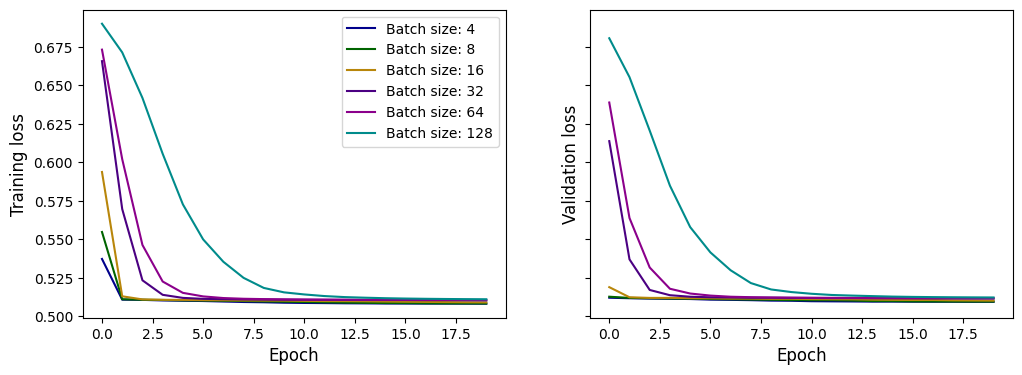

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=True, sharey=True)
for i, history in enumerate(histories):
    ax[0].plot(history.history['loss'], label=f'Batch size: {batch_sizes[i]}', color=custom_colors[i])
    ax[1].plot(history.history['val_loss'], label=f'Batch size: {batch_sizes[i]}', color=custom_colors[i])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Training loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Validation loss')
ax[0].legend()
plt.show()

#### Evaluation

In [20]:
model = clone_model(autoencoder)
model.compile(optimizer='adam', loss='binary_crossentropy')
history = model.fit(
    X_train, X_train,
    epochs=100,
    batch_size=256,
    shuffle=True,
    validation_data=(X_test, X_test)
)

Epoch 1/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5014 - val_loss: 0.4106
Epoch 2/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 0.4360 - val_loss: 0.4093
Epoch 3/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 0.4342 - val_loss: 0.4084
Epoch 4/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - loss: 0.4329 - val_loss: 0.4080
Epoch 5/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 0.4328 - val_loss: 0.4077
Epoch 6/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: 0.4323 - val_loss: 0.4076
Epoch 7/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 0.4324 - val_loss: 0.4076
Epoch 8/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 0.4319 - val_loss: 0.4075
Epoch 9/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - loss: 0.4322 - val_loss: 0.4075
Epoch 10/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - loss: 0.4316 - val_loss: 0.4074
Epoch 11/100
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 0.4319 - val_loss: 0.4074
Epoch 12/100
475/475 

In [15]:
def rmse(orig_signal, decoded_signal):
    return np.sqrt(np.mean((orig_signal - decoded_signal) ** 2))

In [16]:
# encoded_signals = encoder.predict(X_val)
# reconstructed_signals = decoder.predict(encoded_signals)
reconstructed_signals = model.predict(X_val)
rmse_vals = [rmse(X_val[i], reconstructed_signals[i]) for i in range(len(X_val))]

735/735 ━━━━━━━━━━━━━━━━━━━━ 1s 597us/step


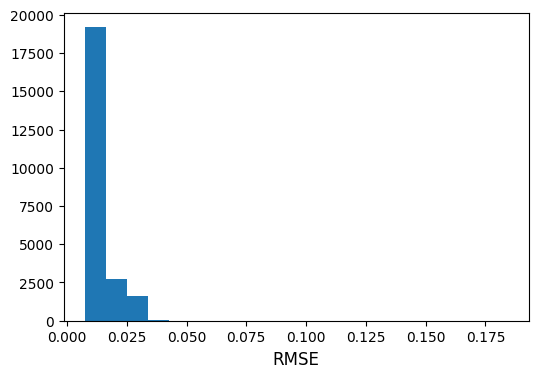

In [17]:
# Plot the RMSE values distribution
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(rmse_vals, bins=20)
ax.set_xlabel('RMSE')
plt.show()

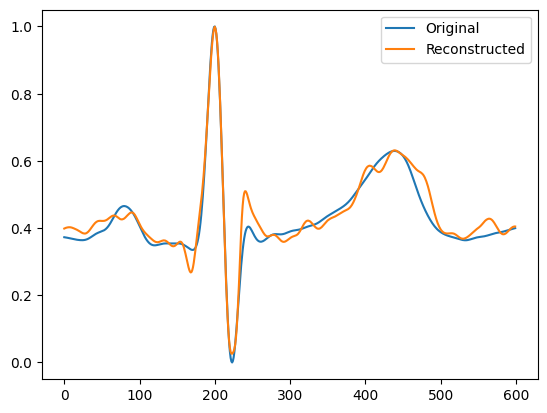

In [18]:
fig, ax = plt.subplots()
ax.plot(X_val[0], label='Original')
ax.plot(reconstructed_signals[0], label='Reconstructed')
ax.legend()
plt.show()

### Deep Autoencoder Model

#### Model Definition

In [19]:
from keras.models import Model
from keras.layers import Input, Dense
from tensorflow.keras.models import clone_model

In [25]:
input_dim = 10000
input_signal = Input(shape=(input_dim,))

encoded = Dense(128, activation='relu')(input_signal)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

deep_autoencoder = Model(input_signal, decoded)
deep_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

#### Hyperparameter Tuning

In [ ]:
batch_size_list = [4, 8, 16, 32, 64, 128]
histories = []
for batch_size in batch_size_list:
    # Start with an untrained model by cloning the model
    model = clone_model(deep_autoencoder)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    history = model.fit(X_train, X_train,
                            epochs=20,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_data=(X_val, X_val)
                        )
    histories.append(history)

In [44]:
with open('experiments/deep_autoencoder_batch_size_history.txt', 'w') as f:
    for i, history in enumerate(histories):
        f.write(f'Batch size: {batch_size_list[i]}\n')
        f.write(f'{history.history}\n')

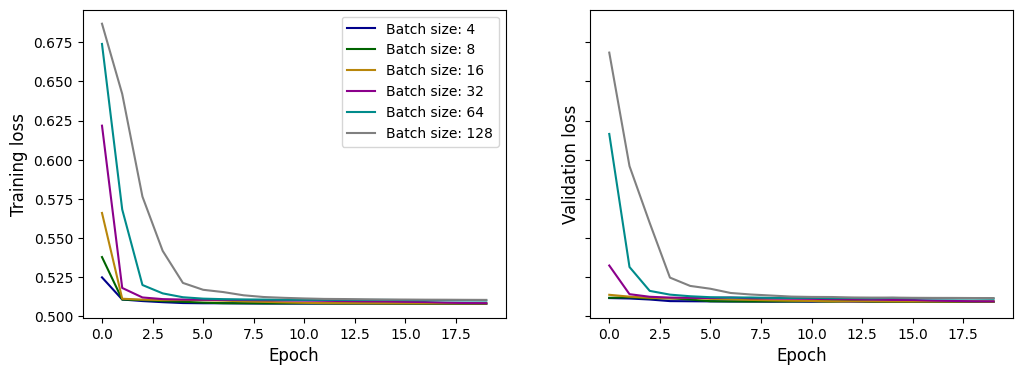

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharey=True)
for i, history in enumerate(histories):
    ax[0].plot(history.history['loss'], label=f'Batch size: {batch_sizes[i]}', color=custom_colors[i])
    ax[1].plot(history.history['val_loss'], label=f'Batch size: {batch_sizes[i]}', color=custom_colors[i])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Training loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Validation loss')
ax[0].legend()
plt.show()

### Evaluation

In [35]:
autoencoder_model = clone_model(autoencoder)
autoencoder_model.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder_model.fit(
    X_train, X_train, 
    epochs=20, 
    batch_size=8, 
    shuffle=True, 
    validation_data=(X_test, X_test)
)

Epoch 1/20
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5803 - val_loss: 0.4913
Epoch 2/20
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - loss: 0.5031 - val_loss: 0.4918
Epoch 3/20
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 0.5020 - val_loss: 0.4943
Epoch 4/20
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 0.4975 - val_loss: 0.4887
Epoch 5/20
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - loss: 0.4969 - val_loss: 0.4896
Epoch 6/20
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 0.4948 - val_loss: 0.4908
Epoch 7/20
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 0.4960 - val_loss: 0.4880
Epoch 8/20
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - loss: 0.4976 - val_loss: 0.4859
Epoch 9/20
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - loss: 0.4961 - val_loss: 0.4883
Epoch 10/20
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 0.4924 - val_loss: 0.4851
Epoch 11/20
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 0.4948 - val_loss: 0.4849
Epoch 12/20
339/339 ━━━━━━━━━━━━

In [36]:
deep_autoencoder_model = clone_model(deep_autoencoder)
deep_autoencoder_model.compile(optimizer='adam', loss='binary_crossentropy')
history = deep_autoencoder_model.fit(
    X_train, X_train, 
    epochs=20, 
    batch_size=32, 
    shuffle=True, 
    validation_data=(X_test, X_test)
)

Epoch 1/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.6095 - val_loss: 0.5136
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5051 - val_loss: 0.4928
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5008 - val_loss: 0.4892
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4973 - val_loss: 0.4879
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4960 - val_loss: 0.4877
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4968 - val_loss: 0.4882
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4961 - val_loss: 0.4876
Epoch 8/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4967 - val_loss: 0.4867
Epoch 9/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4936 - val_loss: 0.4876
Epoch 10/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4930 - val_loss: 0.4863
Epoch 11/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4957 - val_loss: 0.4864
Epoch 12/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4951 - val_l

In [37]:
def rmse(orig_signal, decoded_signal):
    return np.sqrt(np.mean((orig_signal - decoded_signal) ** 2))

In [38]:
autoencoder_reconstructed_signals = autoencoder_model.predict(X_val)
autoencoder_rmse_vals = [rmse(X_val[i], autoencoder_reconstructed_signals[i]) for i in range(len(X_val))]

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [39]:
deep_autoencoder_reconstructed_signals = deep_autoencoder_model.predict(X_val)
deep_autoencoder_rmse_vals = [rmse(X_val[i], deep_autoencoder_reconstructed_signals[i]) for i in range(len(X_val))]

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


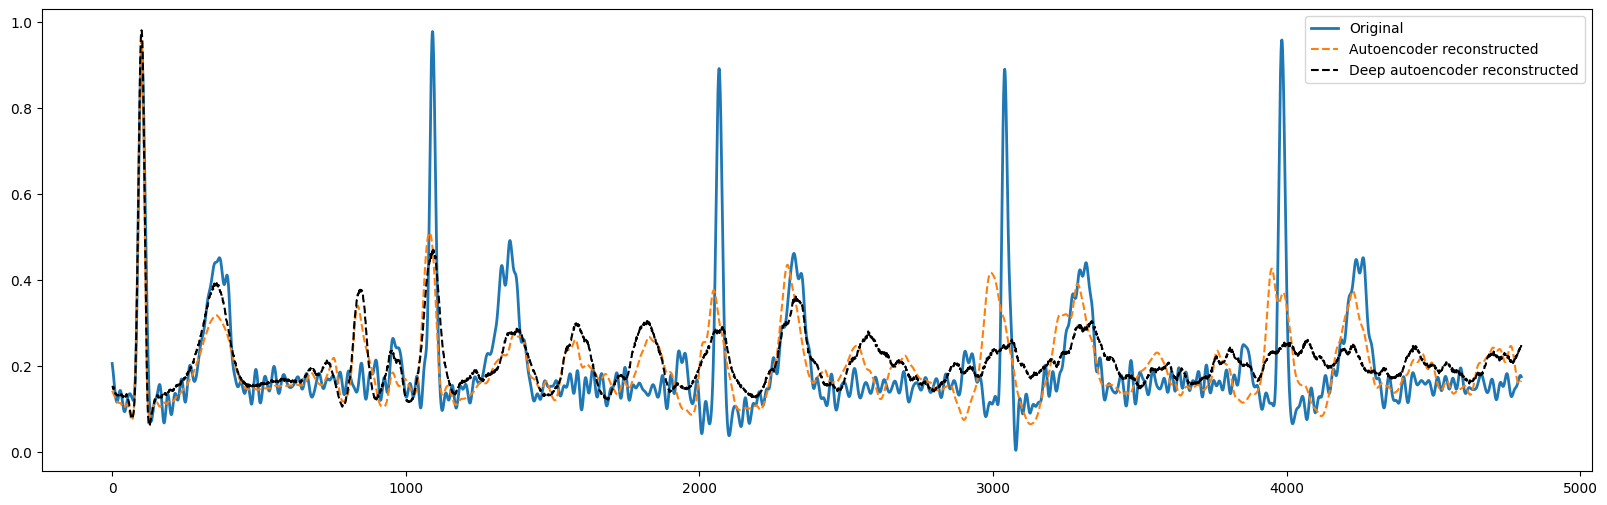

In [45]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(X_val[0][:4800], label='Original', color='tab:blue', linewidth=2)
ax.plot(autoencoder_reconstructed_signals[0][:4800], '--', color='tab:orange', label='Autoencoder reconstructed')
ax.plot(deep_autoencoder_reconstructed_signals[0][:4800], '--', color='black', label='Deep autoencoder reconstructed')
ax.legend()
plt.show()

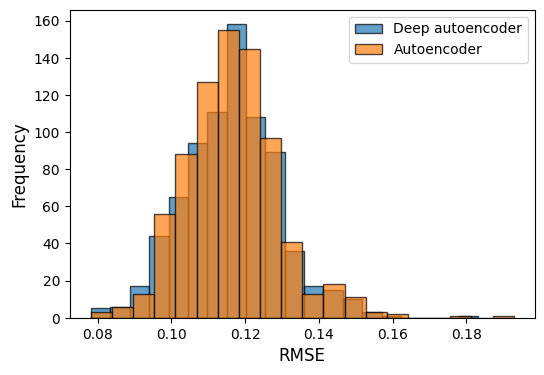

In [41]:
# Plot the RMSE values distribution
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(deep_autoencoder_rmse_vals, bins=20, alpha=0.7, edgecolor='black', label='Deep autoencoder')
ax.hist(autoencoder_rmse_vals, bins=20, alpha=0.7, edgecolor='black', label='Autoencoder')
ax.set_xlabel('RMSE')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

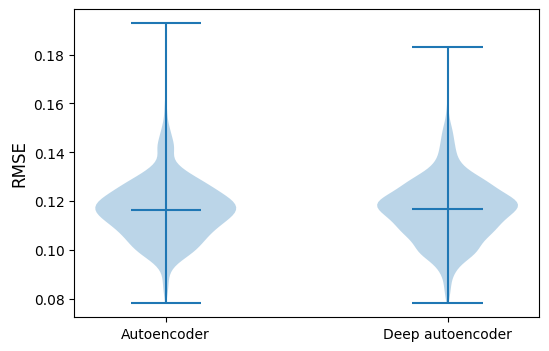

In [42]:
# Plot the RMSE values distribution as violin plots
fig, ax = plt.subplots(figsize=(6, 4))
ax.violinplot([autoencoder_rmse_vals, deep_autoencoder_rmse_vals], showmedians=True)
ax.set_xticks([1, 2])
ax.set_xticklabels(['Autoencoder', 'Deep autoencoder'])
ax.set_ylabel('RMSE')
plt.show()